<a href="https://colab.research.google.com/gist/FokaKefir/496d7cdc44a4e33ea38186aa1ada6457/hf3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import swish

from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta

# Preprocess the data

## Download data

Data was downloaded from: https://www.meteoblue.com/hu/id%C5%91j%C3%A1r%C3%A1s/historyclimate/weatherarchive/nagyk%c5%91r%c3%b6s_magyarorsz%c3%a1g_3047651

In [2]:
!wget -cO weather.csv https://www.dropbox.com/scl/fi/9ncy2zd0cwcyklypkdsdy/weather_long.csv?rlkey=mksbrcsr6vjwg19my1k1wozlp&dl=0

--2023-11-12 17:06:17--  https://www.dropbox.com/scl/fi/9ncy2zd0cwcyklypkdsdy/weather_long.csv?rlkey=mksbrcsr6vjwg19my1k1wozlp
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc489275af439e5779f4a25690f0.dl.dropboxusercontent.com/cd/0/inline/CHY8odnP9S6qwFZB3SHWowK_r7-VpfbKTaYvRhaxzGDDua_JRZko9FzGiD6X9x-iWWS4ue4S6ZGFSIHkSwUUmPMjmUh2Sq8YR0WleqEM6D1utAFc1PnvFfWe-wDCyFcHhpWeLCw79lAVEMDpKEv8q22U/file# [following]
--2023-11-12 17:06:18--  https://uc489275af439e5779f4a25690f0.dl.dropboxusercontent.com/cd/0/inline/CHY8odnP9S6qwFZB3SHWowK_r7-VpfbKTaYvRhaxzGDDua_JRZko9FzGiD6X9x-iWWS4ue4S6ZGFSIHkSwUUmPMjmUh2Sq8YR0WleqEM6D1utAFc1PnvFfWe-wDCyFcHhpWeLCw79lAVEMDpKEv8q22U/file
Resolving uc489275af439e5779f4a25690f0.dl.dropboxusercontent.com (uc489275af439e5779f4a25690f0.dl.dropboxusercontent.com)... 162.125.1.15, 26

## Load in the data

In [3]:
# Load in the data from CSV file
df = pd.read_csv('weather.csv')

# Change date format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

## Show the data

In [4]:
df

,date,Maximum,Minimum,Mean
0,1940-01-02,-3.349755,-8.529755,-6.514754
1,1940-01-03,0.760245,-10.059754,-4.976421
2,1940-01-04,2.480245,-2.669754,0.557329
3,1940-01-05,3.770246,-0.569755,1.566079
4,1940-01-06,4.310245,-3.069755,-0.191005
...,...,...,...,...
30610,2023-10-23,14.030245,6.800245,10.020246
30611,2023-10-24,14.120245,9.770246,11.727328
30612,2023-10-25,15.150246,8.440246,12.129828
30613,2023-10-26,16.170246,10.740245,12.950246


## Seperate the data to train, valid, test

In [5]:
window_size = 90

# Get column names
columns = list(df.columns.values)

# Remove date from that list
columns.remove('date')


# Set the split size of the df
test_split = 0.01
train_size = int(len(df) * (1 - test_split))

# Select the first train_size rows for the training data
train_df = df[columns].head(train_size)


# Select the remaining rows for the test data
test_df = df.tail(len(df) - train_size)

labels_test = []
for i in range(len(test_df)- window_size):
  labels_test.append(test_df.iloc[i+window_size].date)

## Standardize data

In [6]:
mean_at_df = train_df.mean()
std_at_df = train_df.std()
train_df = (train_df - mean_at_df) / std_at_df
test_df = (test_df[columns] - mean_at_df) / std_at_df

In [18]:
mean = mean_at_df.values
std = std_at_df.values
np.save('mean.npy', mean)
np.save('std.npy', std)

In [ ]:
data = train_df.values
test_data = test_df.values

## Make the input and output data for train and validate

In [ ]:
windows = []
outputs = []

for i in range(len(data)- window_size):
  window = data[i:i+window_size]
  output = data[i+window_size]
  windows.append(window)
  outputs.append(output)

x, y = np.array(windows), np.array(outputs)

## Do the same for the test data

In [ ]:
windows_test = []
outputs_test = []

for i in range(len(test_data)- window_size):
  window_test = test_data[i:i+window_size]
  output_test = test_data[i+window_size]
  windows_test.append(window_test)
  outputs_test.append(output_test)

x_test, y_test = np.array(windows_test), np.array(outputs_test)
x_test.shape, y_test.shape

((217, 90, 3), (217, 3))

## Seperate train and valid data

In [ ]:
val_split = 0.20
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=val_split, random_state=42)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((24174, 90, 3), (24174, 3), (6044, 90, 3), (6044, 3))

# Build and train the model

## Build the model

In [ ]:
# Add input layer
i = Input(shape=(window_size, x_train.shape[2]))

# Add LSTM layer(s)
x = LSTM(128, activation='tanh')(i)
#x = LSTM(128, activation='tanh', return_sequences=True)(i)
#x = LSTM(128, activation='tanh', return_sequences=True)(x)
#x = LSTM(32)(x)

# Add MLP layers
x = Dense(x_train.shape[2], activation='linear')(x)

# Build the model and compile
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0003))

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 3)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               67584     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 67971 (265.51 KB)
Trainable params: 67971 (265.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Add callbacks

In [ ]:
early_stopping = EarlyStopping(patience=6, verbose=0)
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=0)


## Train the model

In [ ]:
model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    batch_size=32,
    epochs=15,
    callbacks=[
        early_stopping,
        checkpointer
    ]
)

Epoch 1/15
756/756 [==============================] - 8s 9ms/step - loss: 0.1662 - val_loss: 0.0967
Epoch 2/15
 27/756 [>.............................] - ETA: 4s - loss: 0.0934

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


756/756 [==============================] - 5s 7ms/step - loss: 0.0917 - val_loss: 0.0899
Epoch 3/15
756/756 [==============================] - 6s 8ms/step - loss: 0.0888 - val_loss: 0.0909
Epoch 4/15
756/756 [==============================] - 6s 9ms/step - loss: 0.0883 - val_loss: 0.0877
Epoch 5/15
756/756 [==============================] - 6s 8ms/step - loss: 0.0879 - val_loss: 0.0873
Epoch 6/15
756/756 [==============================] - 5s 7ms/step - loss: 0.0870 - val_loss: 0.0872
Epoch 7/15
756/756 [==============================] - 7s 9ms/step - loss: 0.0864 - val_loss: 0.0871
Epoch 8/15
756/756 [==============================] - 6s 7ms/step - loss: 0.0861 - val_loss: 0.0856
Epoch 9/15
756/756 [==============================] - 6s 8ms/step - loss: 0.0858 - val_loss: 0.0866
Epoch 10/15
756/756 [==============================] - 5s 7ms/step - loss: 0.0855 - val_loss: 0.0873
Epoch 11/15
756/756 [==============================] - 6s 8ms/step - loss: 0.0852 - val_loss: 0.0854
Epoch 12/

# Predict test data and plot

In [ ]:
y_pred = model.predict(x_test)

7/7 [==============================] - 0s 4ms/step


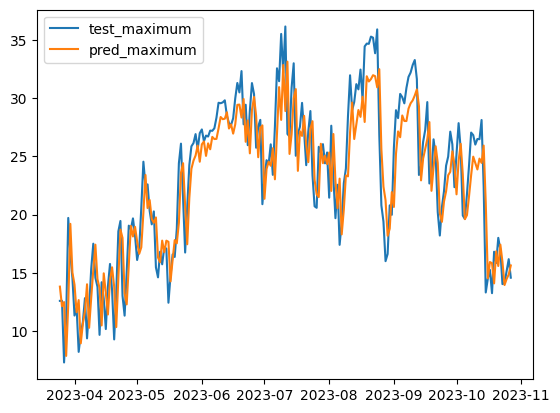

In [ ]:
plt.plot(labels_test, y_test[:, 0] * std[0] + mean[0],  label='test_maximum')
plt.plot(labels_test, y_pred[:, 0] * std[0] + mean[0], label='pred_maximum')
plt.legend()
#plt.xticks(range(len(labels_test)), rotation=90)
plt.show()

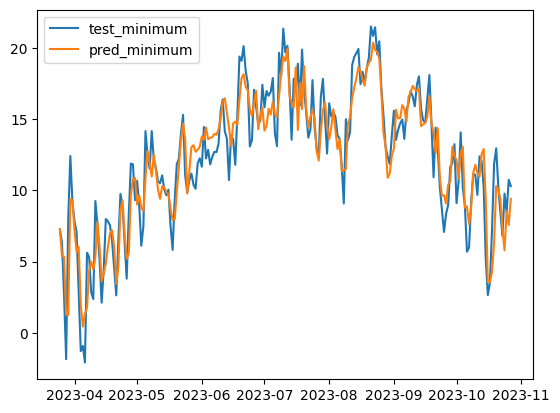

In [ ]:
plt.plot(labels_test, y_test[:, 1] * std[1] + mean[1],  label='test_minimum')
plt.plot(labels_test, y_pred[:, 1] * std[1] + mean[1], label='pred_minimum')
plt.legend()
#plt.xticks(range(len(labels_test)), rotation=90)
plt.show()

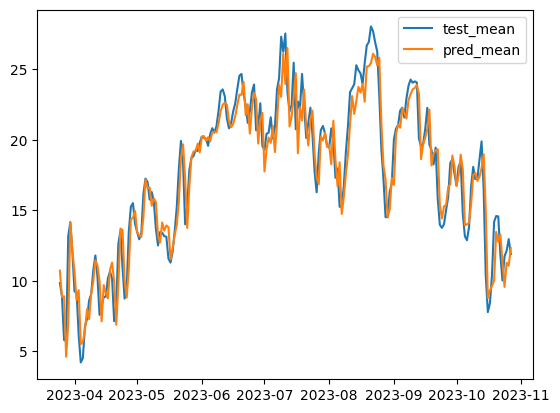

In [ ]:
plt.plot(labels_test, y_test[:, 2] * std[2] + mean[2],  label='test_mean')
plt.plot(labels_test, y_pred[:, 2] * std[2] + mean[2], label='pred_mean')
plt.legend()
#plt.xticks(range(len(labels_test)), rotation=90)
plt.show()

# Forecast test data and plot

In [ ]:
num_forecast = len(labels_test)
date = labels_test[0]
x_in = x_test[0, :]
y_forecasts = []

for _ in range(num_forecast):
  str_date = date.strftime("%Y-%m-%d")
  y_forecast = model.predict(x_in.reshape(1, window_size, -1), verbose=0)
  y_forecast = y_forecast[0]
  x_in[:-1] = x_in[1:]
  x_in[-1] = y_forecast
  y_forecasts.append(y_forecast)
  date += timedelta(days=1)

y_fc = np.array(y_forecasts)

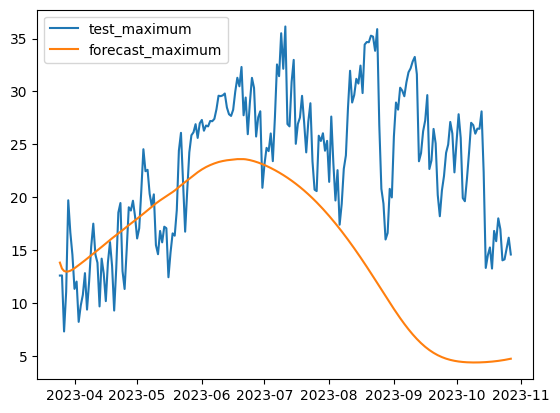

In [ ]:
plt.plot(labels_test, y_test[:, 0] * std[0] + mean[0],  label='test_maximum')
plt.plot(labels_test, y_fc[:, 0]* std[0] + mean[0], label='forecast_maximum')
plt.legend()
plt.show()

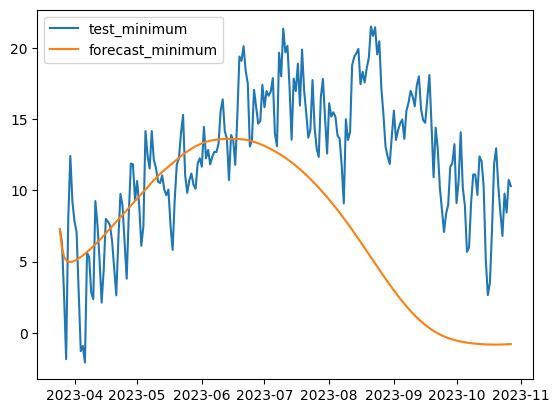

In [ ]:
plt.plot(labels_test, y_test[:, 1] * std[1] + mean[1],  label='test_minimum')
plt.plot(labels_test, y_fc[:, 1] * std[1] + mean[1], label='forecast_minimum')
plt.legend()
plt.show()

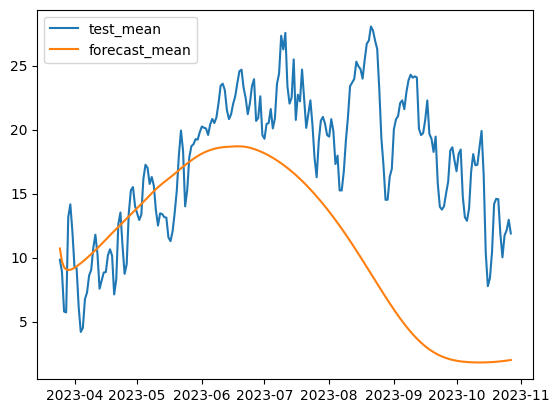

In [ ]:
plt.plot(labels_test, y_test[:, 2] * std[2] + mean[2],  label='test_mean')
plt.plot(labels_test, y_fc[:, 2] * std[2] + mean[2], label='forecast_mean')
plt.legend()
plt.show()

# Make future weather forecast in Budapest

## Download and load pretrained model

In [8]:
!wget -cO weights.hdf5 https://www.dropbox.com/scl/fi/9vj2x5j4ph83dwxhy112y/weather_forecast_weights.hdf5?rlkey=tdb2fq6b40eycsb74bcdi03ed&dl=0

--2023-11-12 17:06:55--  https://www.dropbox.com/scl/fi/9vj2x5j4ph83dwxhy112y/weather_forecast_weights.hdf5?rlkey=tdb2fq6b40eycsb74bcdi03ed
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9b29fe7a4c0982f0c247e7d2d.dl.dropboxusercontent.com/cd/0/inline/CHaVngM3dS78LMxk1FNT2KmJaCZbG_uJk1WeruROSmJbwAZ2GLdtqOkYfv17JHMos4hn9nf7eKU5addNIkNdn6Hx58UTaE4iqKXpe2owO6EF0TBUsOxmbyySN6bwQMh1_F4d8YlFaVE2gtQIVNlTG9Dv/file# [following]
--2023-11-12 17:06:55--  https://uca9b29fe7a4c0982f0c247e7d2d.dl.dropboxusercontent.com/cd/0/inline/CHaVngM3dS78LMxk1FNT2KmJaCZbG_uJk1WeruROSmJbwAZ2GLdtqOkYfv17JHMos4hn9nf7eKU5addNIkNdn6Hx58UTaE4iqKXpe2owO6EF0TBUsOxmbyySN6bwQMh1_F4d8YlFaVE2gtQIVNlTG9Dv/file
Resolving uca9b29fe7a4c0982f0c247e7d2d.dl.dropboxusercontent.com (uca9b29fe7a4c0982f0c247e7d2d.dl.dropboxusercontent.com)... 162

In [9]:
model = load_model('weights.hdf5')

## Download Budapest weather for forecasting

In [20]:
!wget -cO budapest.zip https://www.dropbox.com/scl/fi/qqy4wq9qs9pa6aep9e0mm/budapest.zip?rlkey=ql93ec1tj17nz1qrwqfh966di&dl=0

--2023-11-12 17:12:14--  https://www.dropbox.com/scl/fi/qqy4wq9qs9pa6aep9e0mm/budapest.zip?rlkey=ql93ec1tj17nz1qrwqfh966di
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc796563c5555f73a3c7bff2259.dl.dropboxusercontent.com/cd/0/inline/CHYpbPZOfsQjnAyuNsnu-ueEXFFMkI8gmKwBkxC1BuHPoUlHm4Yi5zQ1ZisTMu70cV5X8ECNb4Clql1VenT9kPnrnFIiZvr3XwV7c2DedwoU-1TatgYN1ou2etK_di7HoFdKVJriokdPSb7OKI37NV3l/file# [following]
--2023-11-12 17:12:15--  https://ucc796563c5555f73a3c7bff2259.dl.dropboxusercontent.com/cd/0/inline/CHYpbPZOfsQjnAyuNsnu-ueEXFFMkI8gmKwBkxC1BuHPoUlHm4Yi5zQ1ZisTMu70cV5X8ECNb4Clql1VenT9kPnrnFIiZvr3XwV7c2DedwoU-1TatgYN1ou2etK_di7HoFdKVJriokdPSb7OKI37NV3l/file
Resolving ucc796563c5555f73a3c7bff2259.dl.dropboxusercontent.com (ucc796563c5555f73a3c7bff2259.dl.dropboxusercontent.com)... 162.125.1.15, 2620:1

In [22]:
!unzip budapest.zip

Archive:  budapest.zip
  inflating: budapest_weather.csv    
  inflating: mean.npy                
  inflating: std.npy                 


## Prepare data

In [23]:
# Load in the data from CSV file
df = pd.read_csv('budapest_weather.csv')

# Change date format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df

,date,Maximum,Minimum,Mean
0,2022-11-12,12.8,4.9,8.7
1,2022-11-13,12.3,2.6,6.4
2,2022-11-14,11.5,3.4,6.4
3,2022-11-15,7.1,2.2,5.8
4,2022-11-16,8.8,7.0,7.9
...,...,...,...,...
361,2023-11-08,12.6,2.6,9.5
362,2023-11-09,14.0,0.0,7.0
363,2023-11-10,9.0,4.0,7.0
364,2023-11-11,8.0,7.0,7.4


In [24]:
window_size = 90

# Get column names
columns = list(df.columns.values)

# Remove date from that list
columns.remove('date')

# copy df
bp_df = df

labels_bp = []
for i in range(len(bp_df)- window_size):
  labels_bp.append(bp_df.iloc[i+window_size].date)

Run "Preprocess the data" section for getting the mean and std

In [25]:
mean = np.load('mean.npy')
std = np.load('std.npy')
bp_df = (bp_df[columns] - mean) / std
bp_data = bp_df.values

In [26]:
windows_test = []
outputs_test = []

for i in range(len(bp_data)- window_size):
  window_test = bp_data[i:i+window_size]
  output_test = bp_data[i+window_size]
  windows_test.append(window_test)
  outputs_test.append(output_test)

x_bp, y_bp = np.array(windows_test), np.array(outputs_test)
x_bp.shape, y_bp.shape

((276, 90, 3), (276, 3))

## Make future forecast

In [27]:
num_forecast = 10
date = labels_bp[-1]
x_in = x_bp[-1, :]

for _ in range(num_forecast):
  str_date = date.strftime("%Y-%m-%d")
  y_forecast = model.predict(x_in.reshape(1, window_size, -1), verbose=0)
  y_forecast = y_forecast[0]
  x_in[:-1] = x_in[1:]
  x_in[-1] = y_forecast
  print(f"{str_date} max: {y_forecast[0] * std[0] + mean[0]:.2f}, min: {y_forecast[1] * std[1] + mean[1]:.2f}, mean: {y_forecast[2]* std[2] + mean[2]:.2f}")
  date += timedelta(days=1)


2023-11-12 max: 9.46, min: 4.99, mean: 7.20
2023-11-13 max: 10.14, min: 4.09, mean: 7.03
2023-11-14 max: 10.72, min: 4.06, mean: 7.19
2023-11-15 max: 11.11, min: 4.23, mean: 7.40
2023-11-16 max: 11.33, min: 4.38, mean: 7.55
2023-11-17 max: 11.43, min: 4.50, mean: 7.64
2023-11-18 max: 11.45, min: 4.56, mean: 7.68
2023-11-19 max: 11.41, min: 4.58, mean: 7.67
2023-11-20 max: 11.33, min: 4.57, mean: 7.64
2023-11-21 max: 11.23, min: 4.54, mean: 7.57
